In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
import pandas as pd

from collections import OrderedDict

In [2]:
def pretty_dataset_name(dataset_name):
    if dataset_name == 'eth':
        return 'ETH - Univ'
    elif dataset_name == 'hotel':
        return 'ETH - Hotel'
    elif dataset_name == 'univ':
        return 'UCY - Univ'
    elif dataset_name == 'zara1':
        return 'UCY - Zara 1'
    elif dataset_name == 'zara2':
        return 'UCY - Zara 2'
    else:
        return dataset_name

# Log-Likelihood Analyses

In [3]:
lls_df = pd.concat([pd.read_csv(f) for f in glob.glob('plots/data/*_lls.csv')], ignore_index=True)

In [4]:
lls_df['NLL'] = -lls_df['log-likelihood']

In [5]:
lls_df.head()

,data_precondition,dataset,method,run,timestep,node,log-likelihood,NLL
0,prev,zara1,sgan,0,0,Pedestrian/1,3.218778,-3.218778
1,prev,zara1,our_full,0,0,Pedestrian/1,5.313984,-5.313984
2,prev,zara1,our_most_likely,0,0,Pedestrian/1,5.448338,-5.448338
3,prev,zara1,sgan,0,1,Pedestrian/1,0.978577,-0.978577
4,prev,zara1,our_full,0,1,Pedestrian/1,4.020490,-4.020490


In [6]:
lls_df[(lls_df['method'] == 'sgan') & (lls_df['dataset'] == 'eth') & (lls_df['data_precondition'] == 'curr')]['log-likelihood'].mean()

-15.69865013054859

In [7]:
specific_df = lls_df[lls_df['data_precondition'] == 'curr']

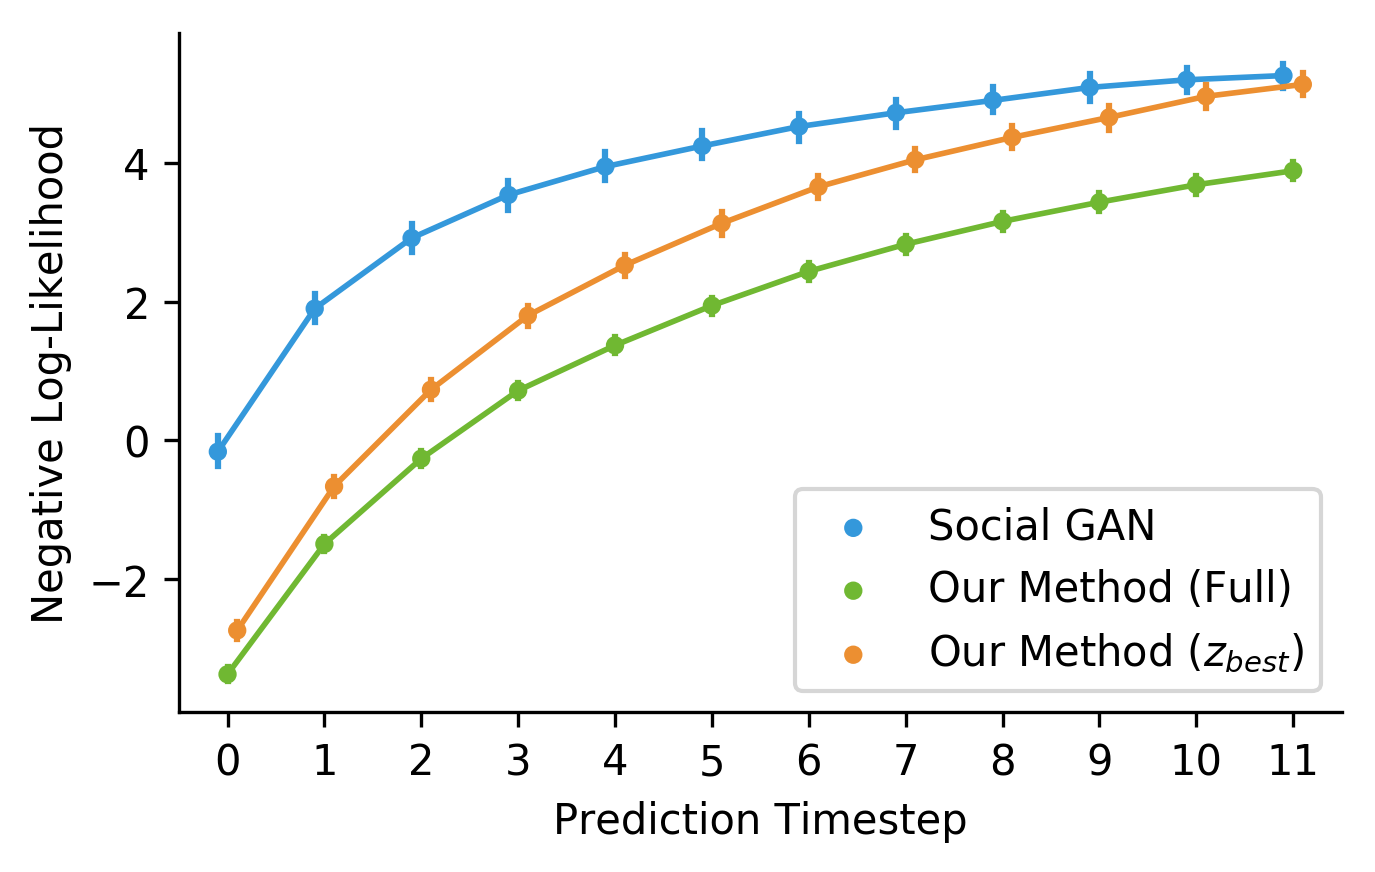

In [8]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
sns.pointplot(y='NLL', x='timestep', data=specific_df,
              hue='method', ax=ax, dodge=0.2, 
              palette=sns.color_palette(['#3498db','#70B832','#EC8F31']),
              scale=0.5, errwidth=1.5)
sns.despine()
ax.set_ylabel('Negative Log-Likelihood')
ax.set_xlabel('Prediction Timestep')

handles, labels = ax.get_legend_handles_labels()
labels = ['Social GAN', 'Our Method (Full)',  r'Our Method ($z_{best}$)']
ax.legend(handles, labels, loc='best');

plt.savefig('plots/paper_figures/nll_vs_time.pdf', dpi=300, bbox_inches='tight')

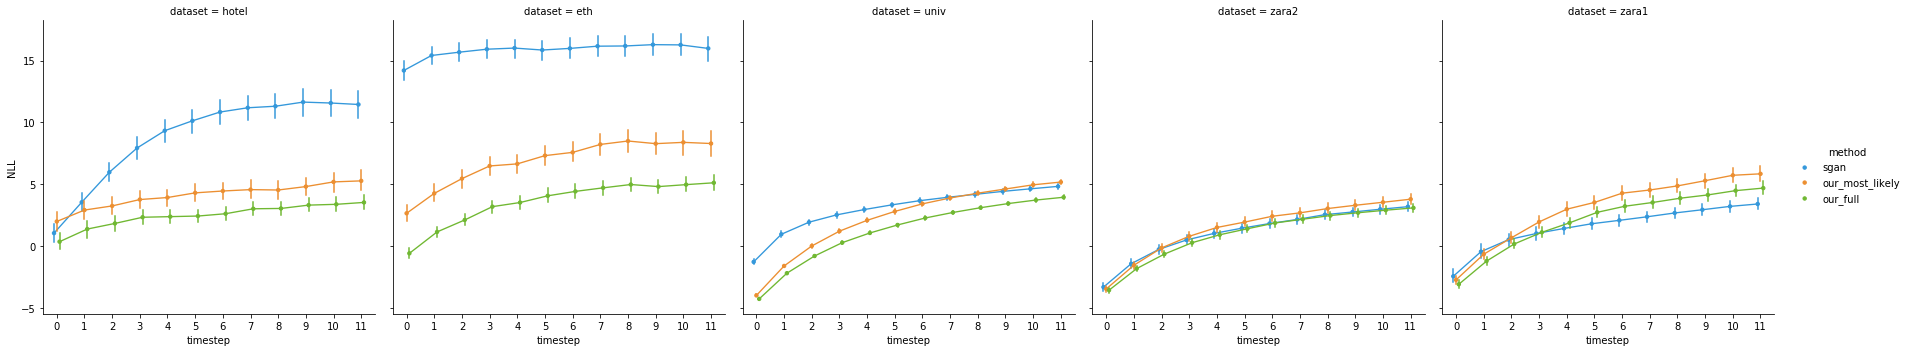

In [9]:
sns.catplot(y='NLL', x='timestep', data=specific_df,
              hue='method', dodge=0.2, kind='point',
              hue_order=['sgan', 'our_most_likely', 'our_full'],
              palette=sns.color_palette(['#3498db','#EC8F31','#70B832']),
              scale=0.5, errwidth=1.5, col='dataset')
sns.despine()

# plt.savefig('plots/paper_figures/nll_vs_time.pdf', dpi=300, bbox_inches='tight')

In [10]:
# data_precondition 	dataset 	method 	run 	timestep 	node 	log-likelihood 	NLL
barplot_df = lls_df[lls_df['data_precondition'] == 'curr'].groupby(['dataset', 'method', 'run', 'node']).mean().reset_index()

In [11]:
del barplot_df['log-likelihood']

In [12]:
barplot_copied_df = barplot_df.copy()
barplot_copied_df['dataset'] = 'Average'

In [13]:
barplot_df = pd.concat([barplot_df, barplot_copied_df], ignore_index=True)

In [14]:
barplot_df.tail()

,dataset,method,run,node,timestep,NLL
38545,Average,sgan,99,Pedestrian/33,4.0,1.222319
38546,Average,sgan,99,Pedestrian/35,5.5,-2.036899
38547,Average,sgan,99,Pedestrian/6,3.0,0.443389
38548,Average,sgan,99,Pedestrian/8,3.0,-0.943852
38549,Average,sgan,99,Pedestrian/9,5.5,8.996832


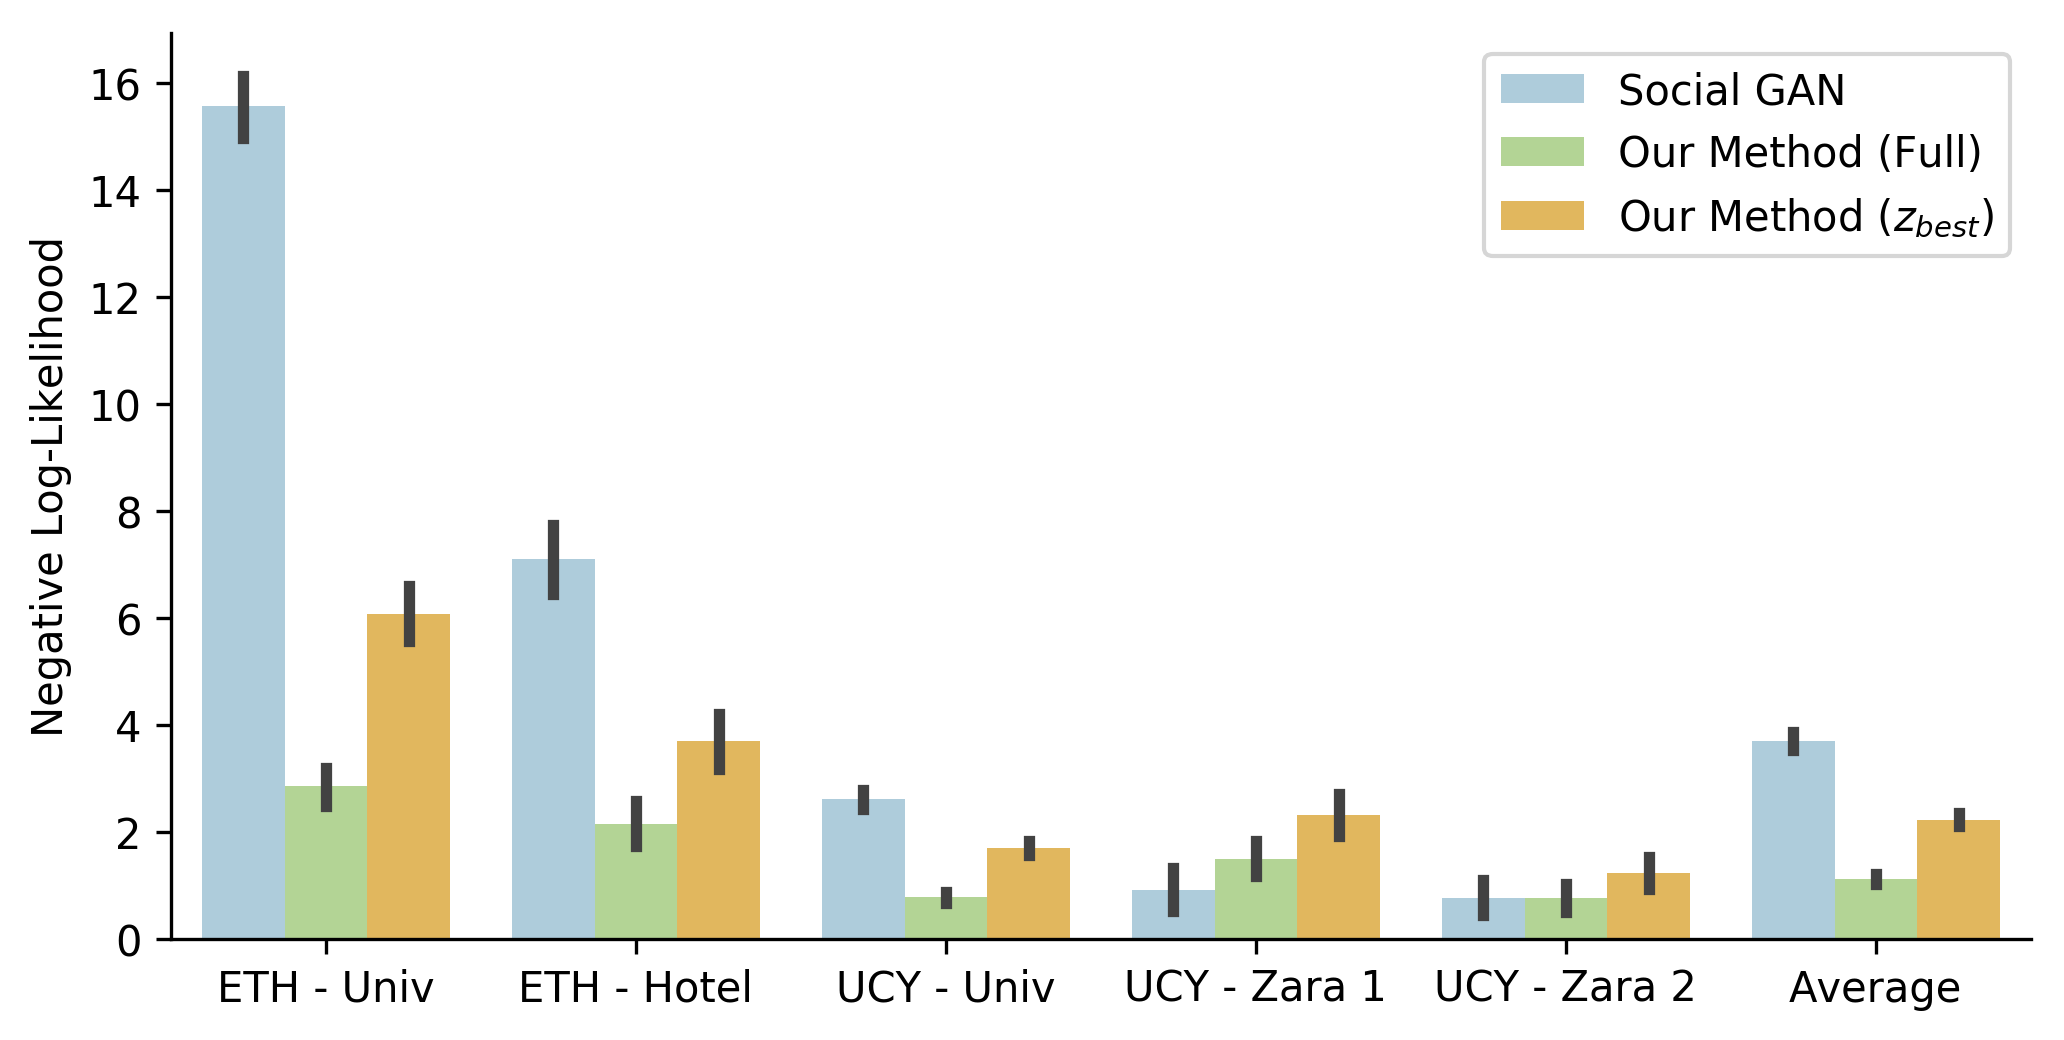

In [15]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
sns.barplot(y='NLL', x='dataset', 
            data=barplot_df,
            hue_order=['sgan', 'our_full', 'our_most_likely'],
            palette=sns.color_palette(['#a6cee3','#b2df8a','#F7BF48']),
            hue='method', dodge=0.2, order=['eth', 'hotel', 'univ', 'zara1', 'zara2', 'Average'])
sns.despine()
ax.set_ylabel('Negative Log-Likelihood')
ax.set_xlabel('')
ax.set_xticklabels([pretty_dataset_name(label.get_text()) for label in ax.get_xticklabels()])

handles, labels = ax.get_legend_handles_labels()
labels = ['Social GAN', 'Our Method (Full)', r'Our Method ($z_{best}$)']
ax.legend(handles, labels, loc='best');

plt.savefig('plots/paper_figures/nll_vs_dataset.pdf', dpi=300, bbox_inches='tight')

In [16]:
from statsmodels.stats.weightstats import ttest_ind, DescrStatsW

In [17]:
sgan_df = lls_df[(lls_df['data_precondition'] == 'curr') & (lls_df['method'] == 'sgan')]
our_ml_df = lls_df[(lls_df['data_precondition'] == 'curr') & (lls_df['method'] == 'our_most_likely')]
our_full_df = lls_df[(lls_df['data_precondition'] == 'curr') & (lls_df['method'] == 'our_full')]

In [18]:
dataset_names = ['eth', 'hotel', 'univ', 'zara1', 'zara2', 'Average']

In [19]:
ll_dict = {'dataset': list(), 'method': list(), 'mean_ll': list(), 
           'conf_int_low': list(), 'conf_int_high': list(), 
           'p_value': list()}

for dataset_name in dataset_names:
    if dataset_name != 'Average':
        curr_sgan_df = sgan_df[sgan_df['dataset'] == dataset_name]
        curr_our_ml_df = our_ml_df[our_ml_df['dataset'] == dataset_name]
        curr_our_full_df = our_full_df[our_full_df['dataset'] == dataset_name]
        
        sgan_nlls = curr_sgan_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        our_ml_nlls = curr_our_ml_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        our_full_nlls = curr_our_full_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        
        sgan_stats = DescrStatsW(sgan_nlls)
        our_ml_stats = DescrStatsW(our_ml_nlls)
        our_full_stats = DescrStatsW(our_full_nlls)
        
        low, high = sgan_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, sgan_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Social GAN')
        ll_dict['mean_ll'].append(sgan_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)
        
        low, high = our_ml_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, our_ml_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Our Method (z_best)')
        ll_dict['mean_ll'].append(our_ml_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)
        
        low, high = our_full_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, our_full_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Our Method (Full)')
        ll_dict['mean_ll'].append(our_full_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)
    else:
        sgan_nlls = sgan_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        our_ml_nlls = our_ml_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        our_full_nlls = our_full_df.groupby(['run', 'node'])['NLL'].mean().reset_index()['NLL']
        
        sgan_stats = DescrStatsW(sgan_nlls)
        our_ml_stats = DescrStatsW(our_ml_nlls)
        our_full_stats = DescrStatsW(our_full_nlls)
        
        low, high = sgan_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, sgan_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Social GAN')
        ll_dict['mean_ll'].append(sgan_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)
        
        low, high = our_ml_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, our_ml_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Our Method (z_best)')
        ll_dict['mean_ll'].append(our_ml_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)
        
        low, high = our_full_stats.tconfint_mean()
        _, p_value, _ = ttest_ind(sgan_nlls, our_full_nlls)
        ll_dict['dataset'].append(dataset_name)
        ll_dict['method'].append('Our Method (Full)')
        ll_dict['mean_ll'].append(our_full_stats.mean)
        ll_dict['conf_int_low'].append(low)
        ll_dict['conf_int_high'].append(high)
        ll_dict['p_value'].append(p_value)

In [20]:
ll_tabular_df = pd.DataFrame.from_dict(ll_dict)

In [21]:
ll_tabular_df

,dataset,method,mean_ll,conf_int_low,conf_int_high,p_value
0,eth,Social GAN,15.570637,14.989196,16.152078,1.000000e+00
1,eth,Our Method (z_best),6.077156,5.554369,6.599943,1.671327e-101
2,eth,Our Method (Full),2.848276,2.499927,3.196624,7.396183e-194
3,hotel,Social GAN,7.096170,6.416055,7.776285,1.000000e+00
4,hotel,Our Method (z_best),3.705019,3.185173,4.224865,1.619704e-14
5,hotel,Our Method (Full),2.150959,1.733587,2.568330,4.105639e-32
6,univ,Social GAN,2.609868,2.429380,2.790355,1.000000e+00
7,univ,Our Method (z_best),1.693765,1.558666,1.828863,1.863138e-15
8,univ,Our Method (Full),0.773702,0.669596,0.877808,1.184845e-65
9,zara1,Social GAN,0.907380,0.499631,1.315130,1.000000e+00


# Displacement Error Analyses

In [22]:
# These are for a prediction horizon of 12 timesteps.
prior_work_mse_results = {
    'ETH - Univ': OrderedDict([('Linear', 1.33), ('Vanilla LSTM', 1.09), ('Social LSTM', 1.09), ('Social Attention', 0.39)]),
    'ETH - Hotel': OrderedDict([('Linear', 0.39), ('Vanilla LSTM', 0.86), ('Social LSTM', 0.79), ('Social Attention', 0.29)]),
    'UCY - Univ': OrderedDict([('Linear', 0.82), ('Vanilla LSTM', 0.61), ('Social LSTM', 0.67), ('Social Attention', 0.20)]),
    'UCY - Zara 1': OrderedDict([('Linear', 0.62), ('Vanilla LSTM', 0.41), ('Social LSTM', 0.47), ('Social Attention', 0.30)]),
    'UCY - Zara 2': OrderedDict([('Linear', 0.77), ('Vanilla LSTM', 0.52), ('Social LSTM', 0.56), ('Social Attention', 0.33)]),
    'Average': OrderedDict([('Linear', 0.79), ('Vanilla LSTM', 0.70), ('Social LSTM', 0.72), ('Social Attention', 0.30)])
}


prior_work_fse_results = {
    'ETH - Univ': OrderedDict([('Linear', 2.94), ('Vanilla LSTM', 2.41), ('Social LSTM', 2.35), ('Social Attention', 3.74)]),
    'ETH - Hotel': OrderedDict([('Linear', 0.72), ('Vanilla LSTM', 1.91), ('Social LSTM', 1.76), ('Social Attention', 2.64)]),
    'UCY - Univ': OrderedDict([('Linear', 1.59), ('Vanilla LSTM', 1.31), ('Social LSTM', 1.40), ('Social Attention', 0.52)]),
    'UCY - Zara 1': OrderedDict([('Linear', 1.21), ('Vanilla LSTM', 0.88), ('Social LSTM', 1.00), ('Social Attention', 2.13)]),
    'UCY - Zara 2': OrderedDict([('Linear', 1.48), ('Vanilla LSTM', 1.11), ('Social LSTM', 1.17), ('Social Attention', 3.92)]),
    'Average': OrderedDict([('Linear', 1.59), ('Vanilla LSTM', 1.52), ('Social LSTM', 1.54), ('Social Attention', 2.59)])
}

linestyles = ['--', '-.', '-', ':']

In [23]:
errors_df = pd.concat([pd.read_csv(f) for f in glob.glob('plots/data/*_errors.csv')], ignore_index=True)

In [24]:
errors_df.head()

,data_precondition,dataset,method,run,node,sample,error_type,error_value
0,prev,zara2,our_full,0,Pedestrian/5,0,mse,0.590357
1,prev,zara2,our_full,0,Pedestrian/5,1,mse,1.021359
2,prev,zara2,our_full,0,Pedestrian/5,2,mse,0.626000
3,prev,zara2,our_full,0,Pedestrian/5,3,mse,0.842233
4,prev,zara2,our_full,0,Pedestrian/5,4,mse,1.286998


In [25]:
dataset_names = ['eth', 'hotel', 'univ', 'zara1', 'zara2', 'Average']

In [26]:
sgan_err_df = errors_df[(errors_df['data_precondition'] == 'curr') & (errors_df['method'] == 'sgan')]
our_ml_err_df = errors_df[(errors_df['data_precondition'] == 'curr') & (errors_df['method'] == 'our_most_likely')]
our_full_err_df = errors_df[(errors_df['data_precondition'] == 'curr') & (errors_df['method'] == 'our_full')]

In [27]:
for dataset_name in dataset_names:
    if dataset_name != 'Average':
        curr_sgan_df = sgan_err_df[sgan_err_df['dataset'] == dataset_name]
        curr_our_ml_df = our_ml_err_df[our_ml_err_df['dataset'] == dataset_name]
        curr_our_full_df = our_full_err_df[our_full_err_df['dataset'] == dataset_name]
        
        sgan_errs = curr_sgan_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        our_ml_errs = curr_our_ml_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        our_full_errs = curr_our_full_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        
        sgan_mse_errs = sgan_errs[sgan_errs['error_type'] == 'mse']['error_value']
        our_ml_mse_errs = our_ml_errs[our_ml_errs['error_type'] == 'mse']['error_value']
        our_full_mse_errs = our_full_errs[our_full_errs['error_type'] == 'mse']['error_value']
        
        sgan_fse_errs = sgan_errs[sgan_errs['error_type'] == 'fse']['error_value']
        our_ml_fse_errs = our_ml_errs[our_ml_errs['error_type'] == 'fse']['error_value']
        our_full_fse_errs = our_full_errs[our_full_errs['error_type'] == 'fse']['error_value']
        
        sgan_mse_stats = DescrStatsW(sgan_mse_errs)
        our_ml_mse_stats = DescrStatsW(our_ml_mse_errs)
        our_full_mse_stats = DescrStatsW(our_full_mse_errs)
        
        sgan_fse_stats = DescrStatsW(sgan_fse_errs)
        our_ml_fse_stats = DescrStatsW(our_ml_fse_errs)
        our_full_fse_stats = DescrStatsW(our_full_fse_errs)
        
        print('\nMSE', dataset_name)
        print('sgan', sgan_mse_stats.mean, sgan_mse_stats.tconfint_mean())
        print('our_ml', our_ml_mse_stats.mean, our_ml_mse_stats.tconfint_mean(), ttest_ind(sgan_mse_errs, our_ml_mse_errs))
        print('our_full', our_full_mse_stats.mean, our_full_mse_stats.tconfint_mean(), ttest_ind(sgan_mse_errs, our_full_mse_errs))
        
        print('FSE', dataset_name)
        print('sgan', sgan_fse_stats.mean, sgan_fse_stats.tconfint_mean())
        print('our_ml', our_ml_fse_stats.mean, our_ml_fse_stats.tconfint_mean(), ttest_ind(sgan_fse_errs, our_ml_fse_errs))
        print('our_full', our_full_fse_stats.mean, our_full_fse_stats.tconfint_mean(), ttest_ind(sgan_fse_errs, our_full_fse_errs))
    
    else:        
        sgan_errs = sgan_err_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        our_ml_errs = our_ml_err_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        our_full_errs = our_full_err_df.groupby(['run', 'node', 'error_type'])['error_value'].mean().reset_index()
        
        sgan_mse_errs = sgan_errs[sgan_errs['error_type'] == 'mse']['error_value']
        our_ml_mse_errs = our_ml_errs[our_ml_errs['error_type'] == 'mse']['error_value']
        our_full_mse_errs = our_full_errs[our_full_errs['error_type'] == 'mse']['error_value']
        
        sgan_fse_errs = sgan_errs[sgan_errs['error_type'] == 'fse']['error_value']
        our_ml_fse_errs = our_ml_errs[our_ml_errs['error_type'] == 'fse']['error_value']
        our_full_fse_errs = our_full_errs[our_full_errs['error_type'] == 'fse']['error_value']
        
        sgan_mse_stats = DescrStatsW(sgan_mse_errs)
        our_ml_mse_stats = DescrStatsW(our_ml_mse_errs)
        our_full_mse_stats = DescrStatsW(our_full_mse_errs)
        
        sgan_fse_stats = DescrStatsW(sgan_fse_errs)
        our_ml_fse_stats = DescrStatsW(our_ml_fse_errs)
        our_full_fse_stats = DescrStatsW(our_full_fse_errs)
        
        print('\nMSE', dataset_name)
        print('sgan', sgan_mse_stats.mean, sgan_mse_stats.tconfint_mean())
        print('our_ml', our_ml_mse_stats.mean, our_ml_mse_stats.tconfint_mean(), ttest_ind(sgan_mse_errs, our_ml_mse_errs))
        print('our_full', our_full_mse_stats.mean, our_full_mse_stats.tconfint_mean(), ttest_ind(sgan_mse_errs, our_full_mse_errs))
        
        print('FSE', dataset_name)
        print('sgan', sgan_fse_stats.mean, sgan_fse_stats.tconfint_mean())
        print('our_ml', our_ml_fse_stats.mean, our_ml_fse_stats.tconfint_mean(), ttest_ind(sgan_fse_errs, our_ml_fse_errs))
        print('our_full', our_full_fse_stats.mean, our_full_fse_stats.tconfint_mean(), ttest_ind(sgan_fse_errs, our_full_fse_errs))


MSE eth
sgan 1.7755483925525664 (1.6025670135245207, 1.948529771580612)
our_ml 0.7935588103623908 (0.7384737142440781, 0.8486439064807035) (10.625445955475964, 3.6767716602405947e-25, 1090.0)
our_full 0.8337114310090893 (0.7787220231973064, 0.8887008388208721) (10.192610449567086, 2.2975970362261235e-23, 1090.0)
FSE eth
sgan 3.2314690748497883 (2.9196665732554252, 3.5432715764441514)
our_ml 1.5628366994626157 (1.4430219285884094, 1.682651470336822) (9.812691912191674, 7.721036218331842e-22, 1090.0)
our_full 1.659339719695458 (1.538724545029271, 1.779954894361645) (9.237226088489251, 1.2846927735955192e-19, 1090.0)

MSE hotel
sgan 1.118493488569662 (1.006917726283549, 1.2300692508557751)
our_ml 0.4812494670252103 (0.4450792781390942, 0.5174196559113264) (10.67136046567556, 2.160691448220736e-25, 1126.0)
our_full 0.5604521601813259 (0.5220320783551339, 0.598872242007518) (9.288541769183487, 7.821721329398014e-20, 1126.0)
FSE hotel
sgan 2.2416090441942584 (2.033112570948833, 2.4501055174

In [28]:
perf_df = errors_df[(errors_df['data_precondition'] == 'curr')]

/home/borisi/anaconda3/envs/dynstg/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


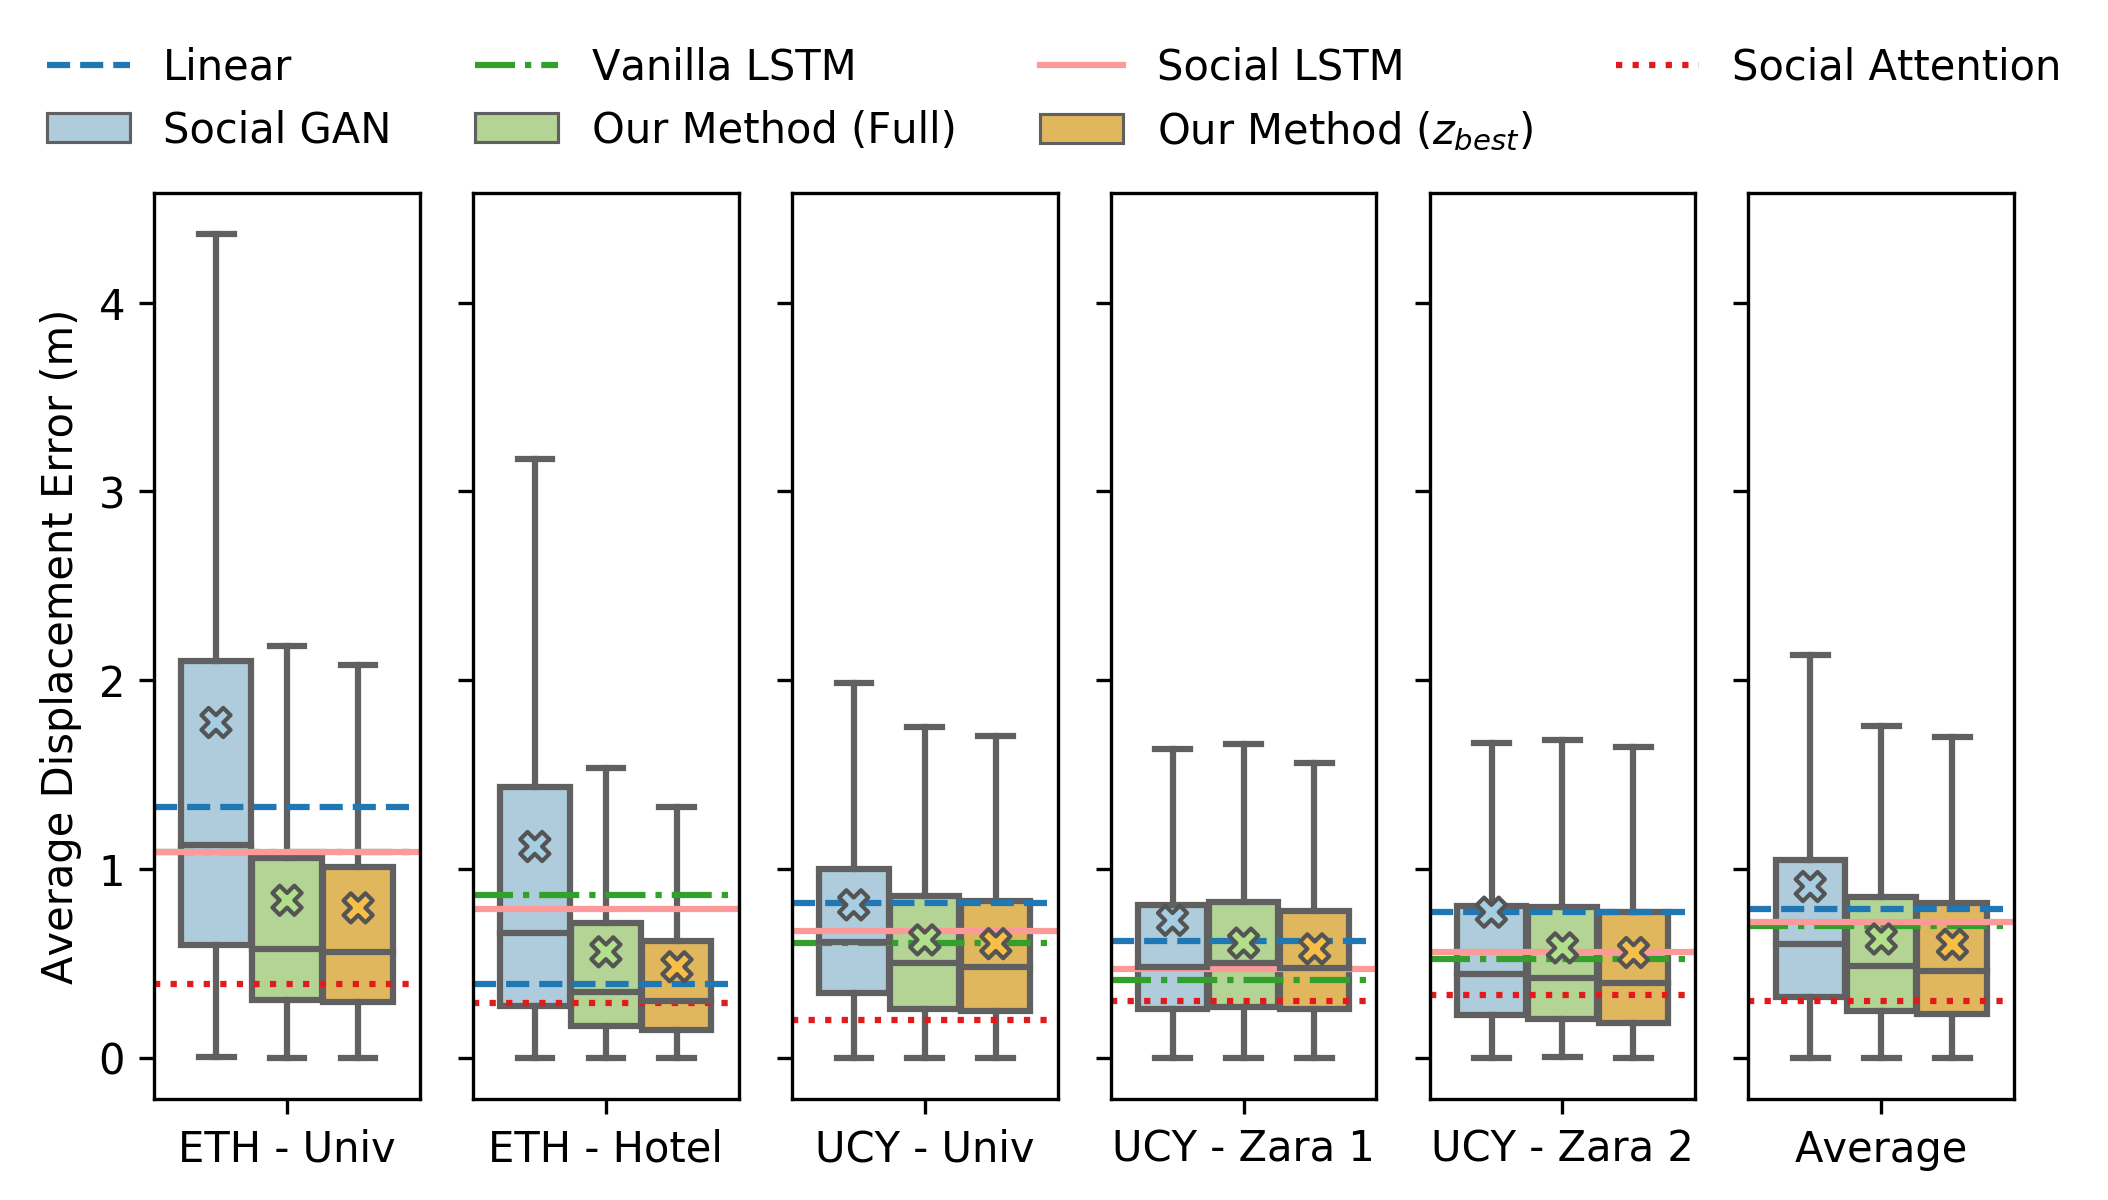

In [29]:
mean_markers = 'X'
marker_size = 7
line_colors = ['#1f78b4','#33a02c','#fb9a99','#e31a1c']
area_colors = ['#a6cee3','#b2df8a','#F7BF48']
area_rgbs = list()
for c in area_colors:
    area_rgbs.append([int(c[i:i+2], 16) for i in (1, 3, 5)])

with sns.color_palette("muted"):
    fig_mse, ax_mses = plt.subplots(nrows=1, ncols=6, figsize=(8, 4), dpi=300, sharey=True)
    for idx, ax_mse in enumerate(ax_mses):
        dataset_name = dataset_names[idx]
        if dataset_name != 'Average':
            specific_df = perf_df[(perf_df['dataset'] == dataset_name) & (perf_df['error_type'] == 'mse')]
            specific_df['dataset'] = pretty_dataset_name(dataset_name)
        else:
            specific_df = perf_df[(perf_df['error_type'] == 'mse')].copy()
            specific_df['dataset'] = 'Average'
        
        sns.boxplot(x='dataset', y='error_value', hue='method',
            data=specific_df, ax=ax_mse, showfliers=False,
            palette=area_colors, hue_order=['sgan', 'our_full', 'our_most_likely'])
        
        for baseline_idx, (baseline, mse_val) in enumerate(prior_work_mse_results[pretty_dataset_name(dataset_name)].items()):
            ax_mse.axhline(y=mse_val, label=baseline, color=line_colors[baseline_idx], linestyle=linestyles[baseline_idx])

        ax_mse.get_legend().remove()
        ax_mse.set_xlabel('')
        ax_mse.set_ylabel('' if idx > 0 else 'Average Displacement Error (m)')
        
        if idx == 0:
            handles, labels = ax_mse.get_legend_handles_labels()
            
            handles = [handles[0], handles[4], handles[1], handles[5], handles[2], handles[6], handles[3]]
            labels = [labels[0], 'Social GAN', labels[1], 'Our Method (Full)', labels[2], r'Our Method ($z_{best}$)', labels[3]]
            
            ax_mse.legend(handles, labels,
                          loc='lower center', bbox_to_anchor=(0.5, 0.9),
                          ncol=4, borderaxespad=0, frameon=False,
                          bbox_transform=fig_mse.transFigure)

        ax_mse.scatter([-0.2675, 0, 0.2675],
               [np.mean(specific_df[specific_df['method'] == 'sgan']['error_value']),
                np.mean(specific_df[specific_df['method'] == 'our_full']['error_value']),
                np.mean(specific_df[specific_df['method'] == 'our_most_likely']['error_value'])],
               s=marker_size*marker_size, c=np.asarray(area_rgbs)/255.0, marker=mean_markers,
               edgecolors='#545454', zorder=10)

#     fig_mse.text(0.51, 0.03, 'Dataset', ha='center')
    
plt.savefig('plots/paper_figures/mse_boxplots.pdf', dpi=300, bbox_inches='tight')

/home/borisi/anaconda3/envs/dynstg/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


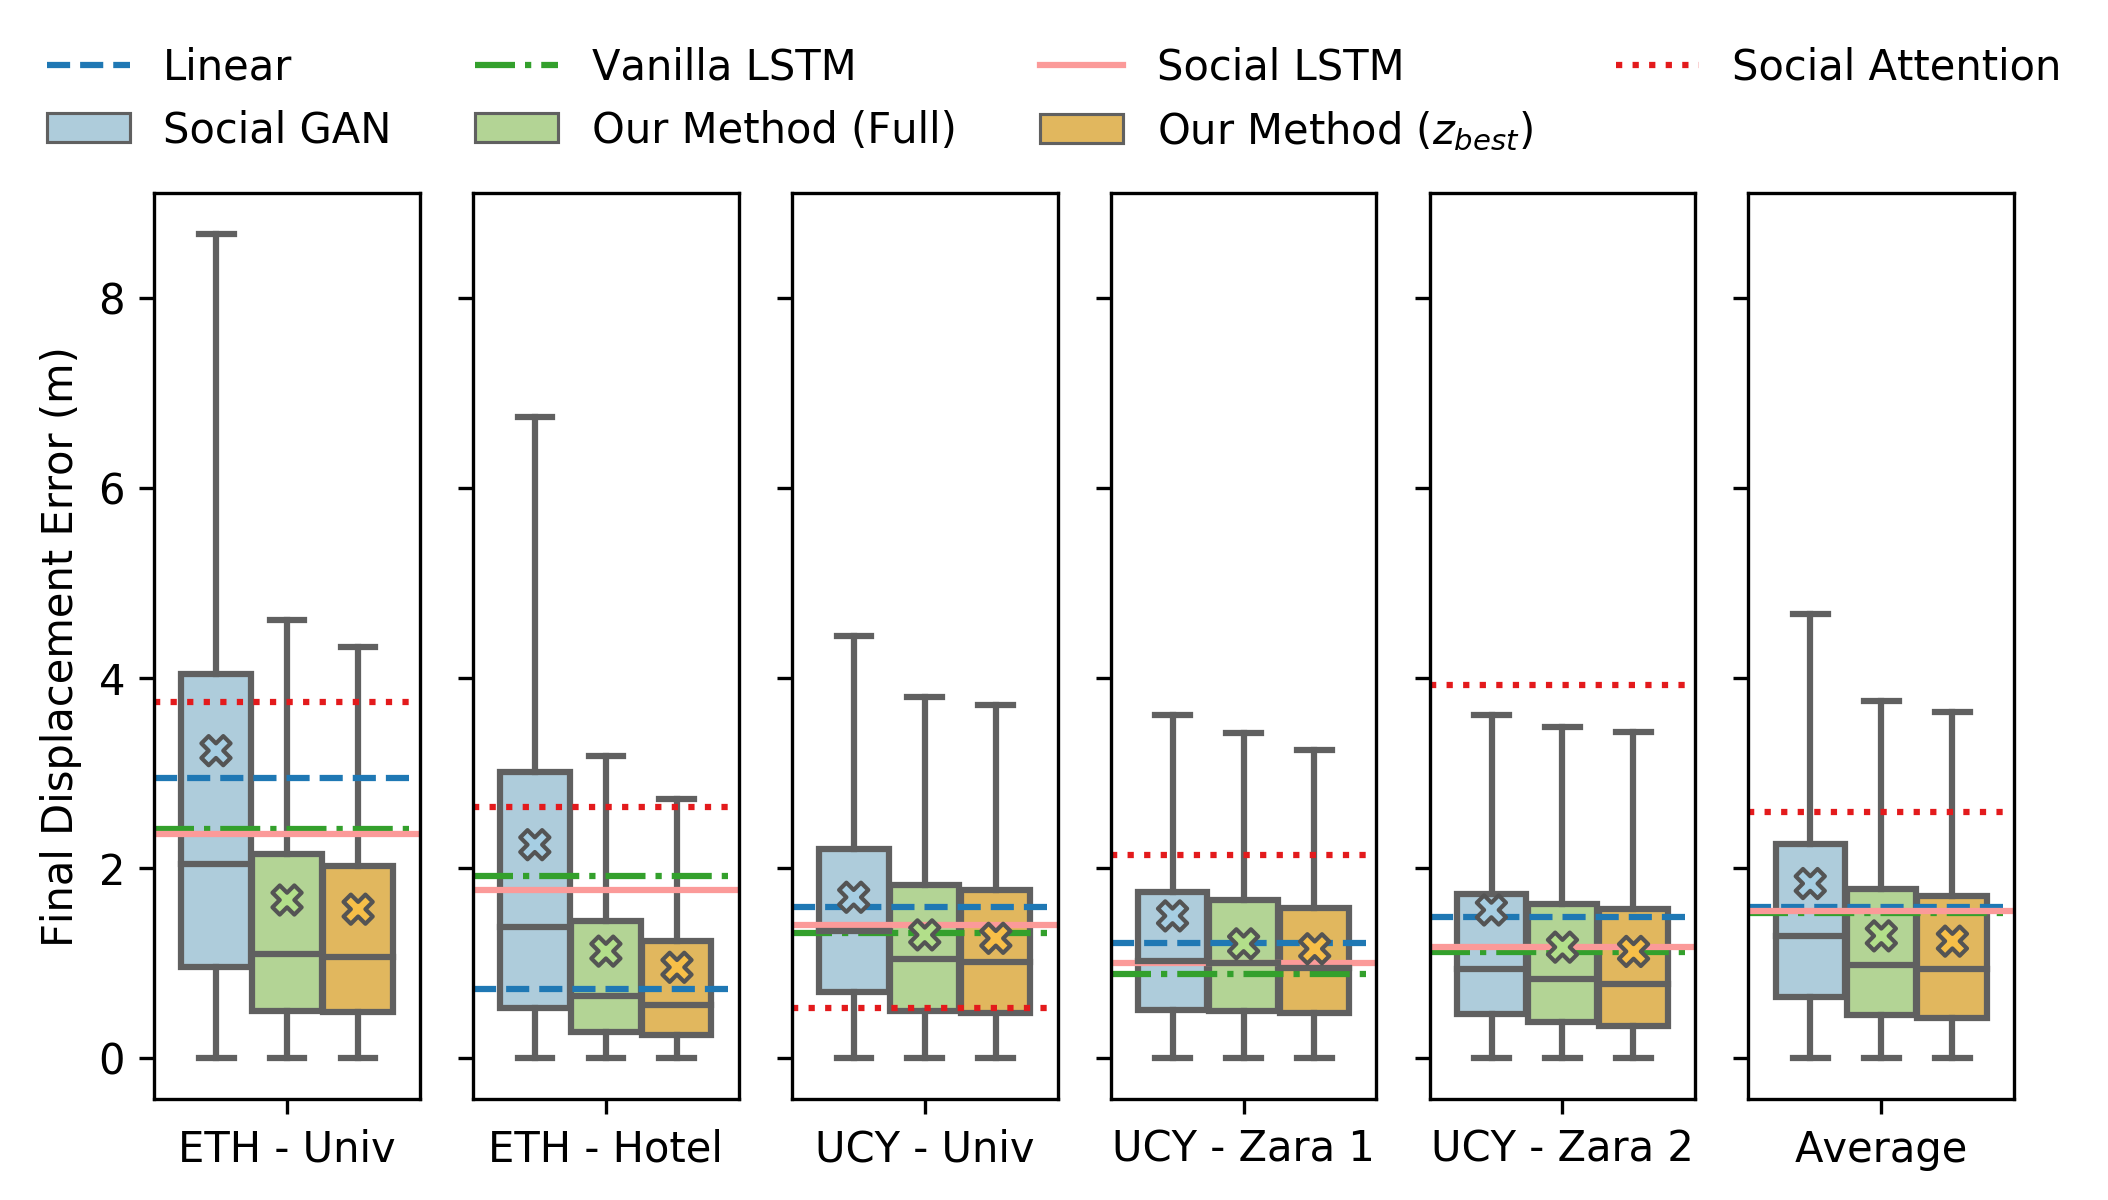

In [30]:
with sns.color_palette("muted"):
    fig_fse, ax_fses = plt.subplots(nrows=1, ncols=6, figsize=(8, 4), dpi=300, sharey=True)
    for idx, ax_fse in enumerate(ax_fses):
        dataset_name = dataset_names[idx]
        if dataset_name != 'Average':
            specific_df = perf_df[(perf_df['dataset'] == dataset_name) & (perf_df['error_type'] == 'fse')]
            specific_df['dataset'] = pretty_dataset_name(dataset_name)
        else:
            specific_df = perf_df[(perf_df['error_type'] == 'fse')].copy()
            specific_df['dataset'] = 'Average'

        sns.boxplot(x='dataset', y='error_value', hue='method',
            data=specific_df, ax=ax_fse, showfliers=False,
            palette=area_colors, hue_order=['sgan', 'our_full', 'our_most_likely'])
        
        for baseline_idx, (baseline, fse_val) in enumerate(prior_work_fse_results[pretty_dataset_name(dataset_name)].items()):
            ax_fse.axhline(y=fse_val, label=baseline, color=line_colors[baseline_idx], linestyle=linestyles[baseline_idx])

        ax_fse.get_legend().remove()
        ax_fse.set_xlabel('')
        ax_fse.set_ylabel('' if idx > 0 else 'Final Displacement Error (m)')

        if idx == 0:
            handles, labels = ax_fse.get_legend_handles_labels()

            handles = [handles[0], handles[4], handles[1], handles[5], handles[2], handles[6], handles[3]]
            labels = [labels[0], 'Social GAN', labels[1], 'Our Method (Full)', labels[2], r'Our Method ($z_{best}$)', labels[3]]

            ax_fse.legend(handles, labels, 
                          loc='lower center', bbox_to_anchor=(0.5, 0.9),
                          ncol=4, borderaxespad=0, frameon=False,
                          bbox_transform=fig_fse.transFigure)

        ax_fse.scatter([-0.2675, 0, 0.2675],
               [np.mean(specific_df[specific_df['method'] == 'sgan']['error_value']),
                np.mean(specific_df[specific_df['method'] == 'our_full']['error_value']),
                np.mean(specific_df[specific_df['method'] == 'our_most_likely']['error_value'])],
               s=marker_size*marker_size, c=np.asarray(area_rgbs)/255.0, marker=mean_markers,
               edgecolors='#545454', zorder=10)

#     fig_fse.text(0.51, 0.03, 'Dataset', ha='center')

plt.savefig('plots/paper_figures/fse_boxplots.pdf', dpi=300, bbox_inches='tight')